# FDTD vs Spectral Methods Baseline Comparison

This notebook compares the Finite-Difference Time-Domain (FDTD) solution for the Relativistic Schrödinger Equation against standard Spectral Propagation methods:
1. **Fresnel Propagation** (Paraxial approximation)
2. **Angular Spectrum Method** (Exact vacuum propagation)
3. **Wave Propagation Method (WPM)** (Wide-angle correction)

We simulate a single atom potential to verify that the FDTD solver converges to the correct steady-state scattering patterns.

In [4]:
%matplotlib widget
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Video
from tqdm import tqdm
import jax
import jax.numpy as jnp

# Add parent directory to path to import jax_multislice
sys.path.append("..") 
from wide_angle_propagation import (
    get_kx_1d,
    fresnel_kernel_1d,
    angular_spectrum_kernel_1d,
    propagate_1d,
    wpm_kernel_1d_vmap
)
from wide_angle_propagation import RelativisticSolver, calculate_physics_params, SOL_LIGHT, MASS_PART

# Configure JAX
jax.config.update("jax_enable_x64", True)

## 1. Simulation Parameters & Potential Generation

We define a 2D grid and a physical potential $V(r)$. 
For consistency, we use the same relativistic kinematics for all methods.

**Physics:**
- Wavelength $\lambda = 0.025$ Å (High energy electrons)
- Potential: Single Coulomb center (representing an Atom)

Physics Parameters:
  Wavelength: 0.025 Å
  k0: 132.9967 a.u.
  E_sim: 8844.0663 a.u.
Grid Dimensions:
  ROI:  1024x1024 (Y=[-1.50, 1.50])
  FDTD: 1024x1398 (Y=[-2.05, 2.05])
Configuration:
  Total Padding: 0.5500
  PML Thickness: 0.4000
  Gap for Source:0.1500


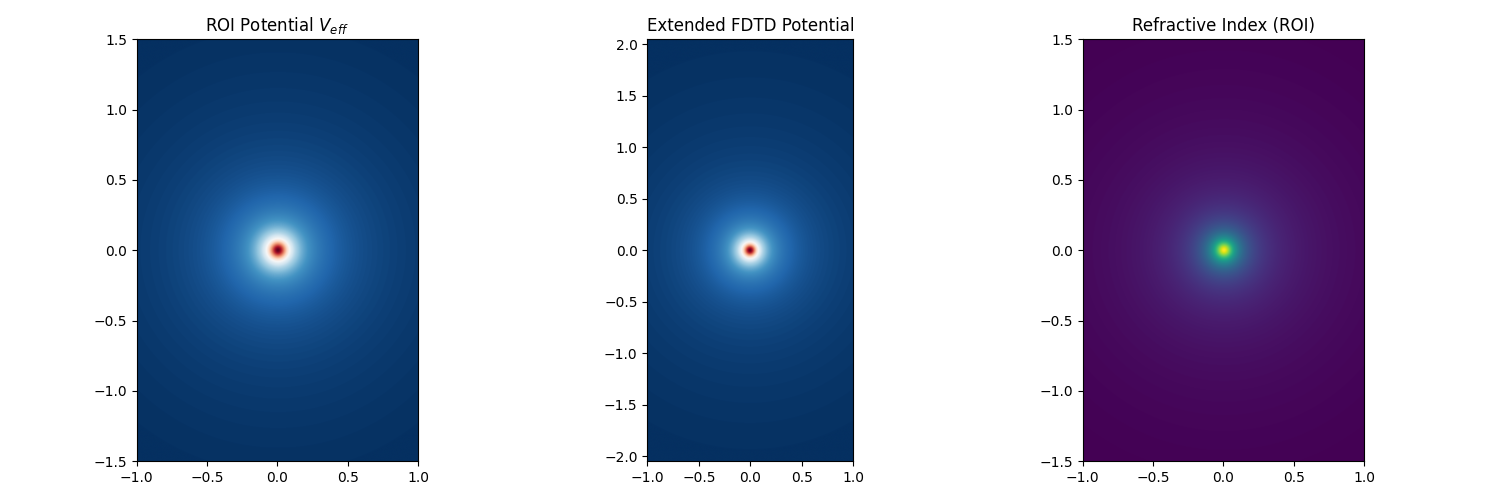

In [5]:
# --- 1. Physics Configuration ---
WAVELENGTH_ANGSTROM = 0.025
E_TOTAL, P_INF, E_SIM = calculate_physics_params(WAVELENGTH_ANGSTROM)
k0 = P_INF 

print(f"Physics Parameters:\n  Wavelength: {WAVELENGTH_ANGSTROM} Å\n  k0: {k0:.4f} a.u.\n  E_sim: {E_SIM:.4f} a.u.")

# --- 2. Grid Setup ---
NX, ROI_NY = 1024, 1024
ROI_XMIN, ROI_XMAX = -1.0, 1.0
ROI_YMIN, ROI_YMAX = -1.5, 1.5

# Arrays
x = np.linspace(ROI_XMIN, ROI_XMAX, NX)
y = np.linspace(ROI_YMIN, ROI_YMAX, ROI_NY)
dx, dy = x[1] - x[0], y[1] - y[0]
X, Y = np.meshgrid(x, y, indexing='xy')
extent = [ROI_XMIN, ROI_XMAX, ROI_YMIN, ROI_YMAX]

# Compatibility variables
XMIN, XMAX, YMIN, YMAX = ROI_XMIN, ROI_XMAX, ROI_YMIN, ROI_YMAX
NX_ROI, NY, NY_ROI = NX, ROI_NY, ROI_NY

# --- 3. Extended Grid for FDTD ---
# Precise Padding Logic to ensure: EXT_YMIN < PML_END < SOURCE < ROI_YMIN
PML_THICKNESS = 0.4      # Absorbing layer thickness (a.u.)
SOURCE_Buffer = 0.15     # Gap between PML and Source / Source and ROI
Y_PAD = PML_THICKNESS + SOURCE_Buffer 

EXT_YMIN, EXT_YMAX_TARGET = ROI_YMIN - Y_PAD, ROI_YMAX + Y_PAD
EXT_NY = int(np.round((EXT_YMAX_TARGET - EXT_YMIN) / dy))
y_ext = np.linspace(EXT_YMIN, EXT_YMIN + (EXT_NY-1)*dy, EXT_NY)
EXT_YMAX = y_ext[-1] # Adjusted max
X_EXT, Y_EXT = np.meshgrid(x, y_ext, indexing='xy')
extent_ext = [ROI_XMIN, ROI_XMAX, EXT_YMIN, EXT_YMAX]

print(f"Grid Dimensions:")
print(f"  ROI:  {NX}x{ROI_NY} (Y=[{ROI_YMIN:.2f}, {ROI_YMAX:.2f}])")
print(f"  FDTD: {NX}x{EXT_NY} (Y=[{EXT_YMIN:.2f}, {EXT_YMAX:.2f}])")
print(f"Configuration:")
print(f"  Total Padding: {Y_PAD:.4f}")
print(f"  PML Thickness: {PML_THICKNESS:.4f}")
print(f"  Gap for Source:{SOURCE_Buffer:.4f}")

# --- 4. Potential Generation ---
def get_potentials(x_grid, y_grid):
    # Single Au Atom (Z=79) with regularization
    r = np.sqrt(x_grid**2 + y_grid**2 + 0.05**2)
    V_phys = -79.0 / r
    
    # Effective Potential for Relativistic FDTD
    # V_eff = E_sim - 0.5 * k_local^2
    term1 = (E_TOTAL - V_phys)
    term2 = MASS_PART * SOL_LIGHT**2
    k2_local = (term1**2 - term2**2) / (SOL_LIGHT**2)
    V_eff = E_SIM - 0.5 * k2_local
    
    # Refractive Index for BPM
    n_index = np.sqrt(k2_local) / k0
    return V_phys, V_eff, n_index

# Generate Potentials
V_phys, V_eff, n_map = get_potentials(X, Y)
_, V_eff_fdtd, _ = get_potentials(X_EXT, Y_EXT)

# Visualization
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plot_opts = {'origin': 'upper', 'cmap': 'RdBu'}
ax[0].imshow(V_eff, extent=extent, **plot_opts)
ax[0].set_title("ROI Potential $V_{eff}$")
ax[1].imshow(V_eff_fdtd, extent=extent_ext, **plot_opts)
ax[1].set_title("Extended FDTD Potential")
ax[2].imshow(n_map, extent=extent, origin='upper', cmap='viridis')
ax[2].set_title("Refractive Index (ROI)")
plt.tight_layout()
plt.show()

## 2. FDTD Simulation (Ground Truth)

Running the CUDA-accelerated FDTD solver until steady state.

--- Running FDTD Simulation ---
  Frames: 1, Steps/Frame: 150000
  Total Steps: 150000
  Boundary Config:
    PML Thickness: 0.4000 a.u.
    Source Index:  156 (y_rel = 0.4575)
    ROI Start at:  0.5500 a.u.
    Valid Order:   0.400 < 0.457 < 0.550 ? YES
Running: fdtd_open_boundaries 1 150000 1 -0.025
Loaded 1 snapshots.
Measured Incident Intensity: 0.443058
Cropped to ROI indices [188:1212]


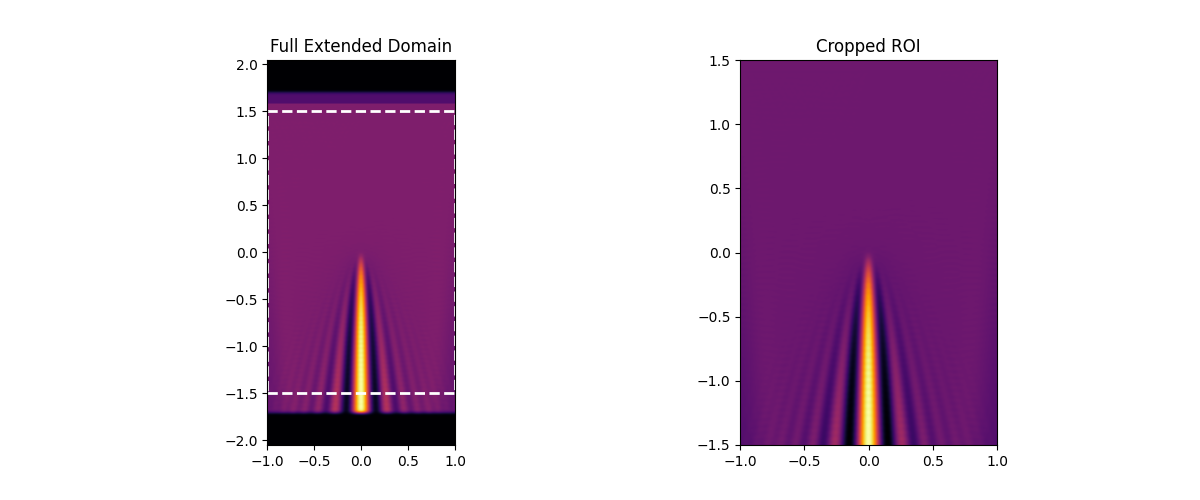

In [6]:
def run_fdtd_simulation(V_map, extent_full, extent_roi, n_frames=200, steps_per_frame=2500):
    """
    Runs FDTD simulation, normalizes to incident intensity, and crops to ROI.
    """
    solver = RelativisticSolver()
    
    # Calculate total duration for info
    total_steps = n_frames * steps_per_frame
    print(f"--- Running FDTD Simulation ---")
    print(f"  Frames: {n_frames}, Steps/Frame: {steps_per_frame}")
    print(f"  Total Steps: {total_steps}")
    
    # Improved Boundary Parameters
    curr_dy = dy if 'dy' in globals() else 0.006
    
    # 1. Use defined thicknesses from previous cell if available
    pml_thick = PML_THICKNESS if 'PML_THICKNESS' in globals() else 0.4
    pad_total = Y_PAD if 'Y_PAD' in globals() else 0.6
    
    # 2. Gentle PML sigma to reduce impedance mismatch
    pml_sigma = 80.0
    
    # 3. Calculate Source Injection Index relative to Local Grid (Ext)
    # Location: After PML, but before ROI
    # Let's put it ~20 pixels after the PML ends
    j_source_idx = int(pml_thick / curr_dy) + 20
    
    # Verify Source Location
    y_source_rel = j_source_idx * curr_dy # distance from top of EXT grid
    if y_source_rel >= pad_total:
        print(f"WARNING: Source index {j_source_idx} (y={y_source_rel:.3f}) is INSIDE the ROI (Pad={pad_total:.3f})!")
        print("Adjusting source to be mid-gap...")
        gap_mid = (pml_thick + pad_total) / 2.0
        j_source_idx = int(gap_mid / curr_dy)
        
    print(f"  Boundary Config:")
    print(f"    PML Thickness: {pml_thick:.4f} a.u.")
    print(f"    Source Index:  {j_source_idx} (y_rel = {j_source_idx*curr_dy:.4f})")
    print(f"    ROI Start at:  {pad_total:.4f} a.u.")
    print(f"    Valid Order:   {pml_thick:.3f} < {j_source_idx*curr_dy:.3f} < {pad_total:.3f} ? {'YES' if (pml_thick < j_source_idx*curr_dy < pad_total) else 'NO'}")
    
    sim_result = solver.run(
        V_map.astype(np.float32), 
        wavelength_angstrom=WAVELENGTH_ANGSTROM,
        extent=extent_full,
        n_frames=n_frames,      
        steps_per_frame=steps_per_frame, 
        snapshot_count=n_frames, # Save all frames for video
        pml_thick=pml_thick,     # Explicit PML thickness
        pml_sigma=pml_sigma,     # PML strength
        j_source=j_source_idx    # Precise source location
    )
    
    if not sim_result:
        raise RuntimeError("Simulation Failed")
        
    snapshots = sim_result['snapshots']
    E_sim_val = sim_result['E_sim']
    
    # 1. Integrate Steady State
    psi_ext = np.zeros_like(snapshots[0][1], dtype=np.complex128)
    # Average last 30% of frames
    start_avg = int(0.7 * len(snapshots))
    # Safety check if we have enough frames
    if start_avg >= len(snapshots): start_avg = 0
    
    count = 0
    for t, phi, psi in snapshots[start_avg:]:
        phasor = np.exp(1j * E_sim_val * t) 
        psi_ext += (phi + 1j * psi) * phasor
        count += 1
    
    if count > 0:
        psi_ext /= count
    
    # 2. Normalization (Incident Intensity = 1.0)
    # Monitor well after source injection (Source + 50)
    # But before ROI if possible, or inside ROI where V=0
    i_monitor = j_source_idx + 40
    I_incident = np.mean(np.abs(psi_ext[i_monitor, :])**2)
    print(f"Measured Incident Intensity: {I_incident:.6f}")
    if I_incident > 1e-9:
        psi_ext *= (1.0 / np.sqrt(I_incident))
        
    # 3. Crop to ROI
    # ROI starts at EXT_YMIN + Y_PAD
    # We can calculate indices from extent
    y_full = np.linspace(extent_full[2], extent_full[3], V_map.shape[0])
    # Find closest indices
    idx_start = np.argmin(np.abs(y_full - extent_roi[2]))
    idx_end = idx_start + NY_ROI 
    
    # Ensure bounds
    if idx_end > V_map.shape[0]: idx_end = V_map.shape[0]

    psi_cropped = psi_ext[idx_start:idx_end, :]
    
    print(f"Cropped to ROI indices [{idx_start}:{idx_end}]")
    return psi_cropped, psi_ext, snapshots

# Execute - Using fewer frames but more steps per frame to save disk space
psi_fdtd, psi_fdtd_ext, snapshots = run_fdtd_simulation(
    V_eff_fdtd, 
    extent_ext, 
    extent, 
    n_frames=1, 
    steps_per_frame=1200 * 125
)

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(np.abs(psi_fdtd_ext)**2, extent=extent_ext, origin='upper', cmap='inferno')
ax[0].set_title("Full Extended Domain")
ax[0].add_patch(plt.Rectangle((ROI_XMIN, ROI_YMIN), ROI_XMAX-ROI_XMIN, ROI_YMAX-ROI_YMIN, 
                     lw=2, ec='w', fc='none', ls='--'))

ax[1].imshow(np.abs(psi_fdtd)**2, extent=extent, origin='upper', cmap='inferno')
ax[1].set_title("Cropped ROI")
plt.show()

## 3. Spectral Methods (Fresnel, AS, WPM)

We propagate a plane wave slice-by-slice through the same potential map.
Structure: $\psi(x, y+\Delta y) = \text{Propagate}(\psi(x, y) \cdot e^{i \Delta \phi}, \Delta y)$

WPM Adaptive: 100%|██████████| 1023/1023 [00:06<00:00, 150.08it/s]


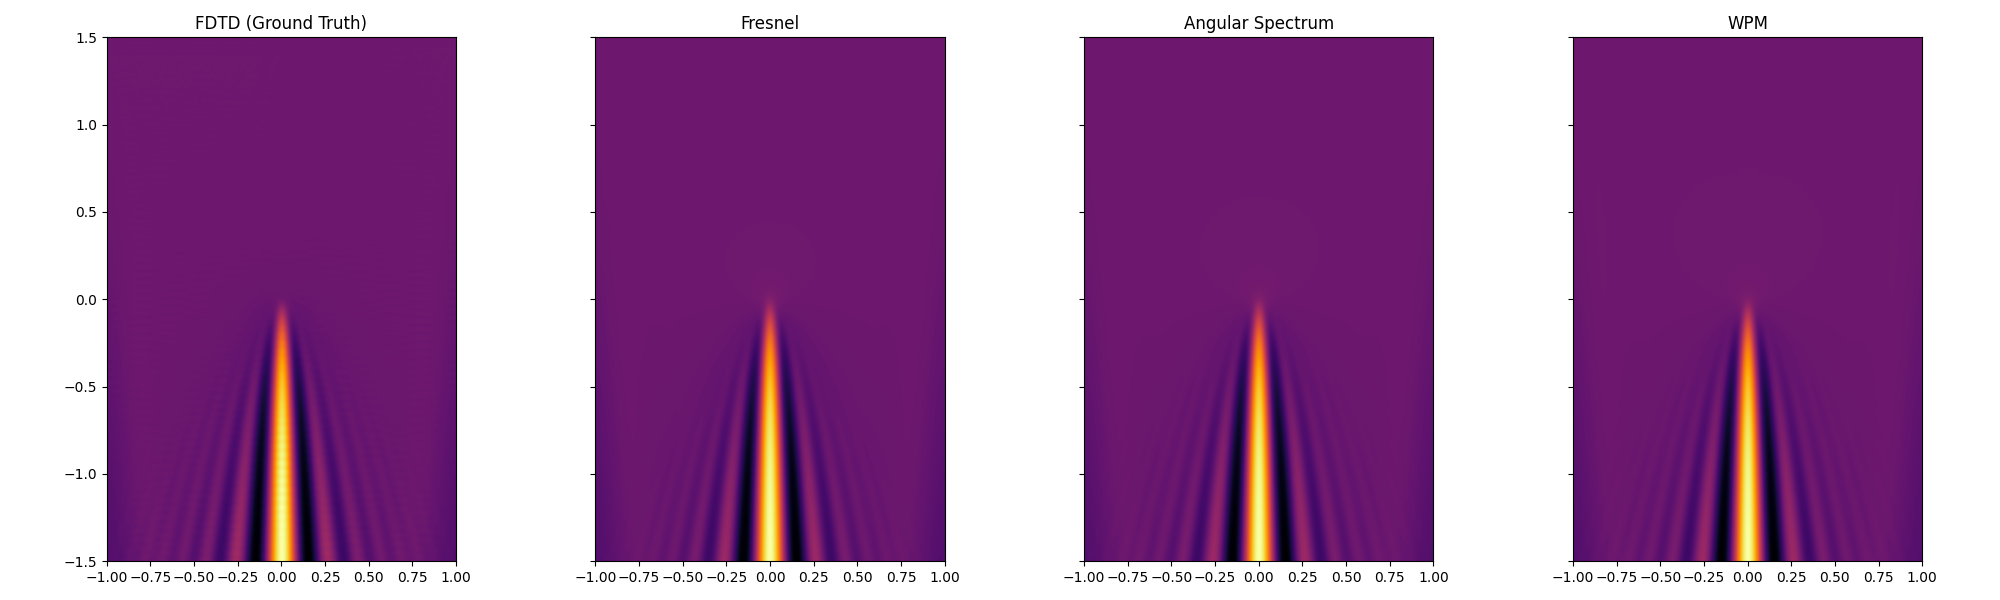

In [7]:
# --- Spectral Propagation Methods (use package 1D helpers) ---
# Pre-calculate frequencies (angular) using package helper
kx = get_kx_1d(NX, dx)
k_perp_sq = kx**2

# Use vmapped WPM kernel provided by the package: wpm_kernel_1d_vmap
def run_wpm(n_bins=32):
    psi = jnp.ones(NX, dtype=jnp.complex128)
    wavefield = [psi]
    for i in tqdm(range(NY-1), desc="WPM Adaptive"):
        n_slice = 0.5 * (n_map[i, :] + n_map[i+1, :])
        psi_k = jnp.fft.fft(psi)
        n_min, n_max = n_slice.min(), n_slice.max()
        t = jnp.linspace(0, 1, n_bins)
        n_refs = n_min + (n_max - n_min) * (t**2)
        kx_sq = kx**2
        kx_sq = kx_sq.astype(jnp.complex128)
        prop_bank = wpm_kernel_1d_vmap(psi_k, n_refs, k0, kx_sq, dy)
        idx_R = jnp.searchsorted(n_refs, n_slice)
        idx_R = jnp.clip(idx_R, 1, n_bins - 1)
        idx_L = idx_R - 1
        n_L = n_refs[idx_L]
        n_R = n_refs[idx_R]
        w_raw = (n_slice - n_L) / (n_R - n_L + 1e-15)
        w = jnp.clip(3*w_raw**2 - 2*w_raw**3, 0.0, 1.0)
        psi_L = jnp.take_along_axis(prop_bank, idx_L[None, :], axis=0).squeeze()
        psi_R = jnp.take_along_axis(prop_bank, idx_R[None, :], axis=0).squeeze()
        psi = (1 - w) * psi_L + w * psi_R
        wavefield.append(psi)
    return jnp.array(wavefield)

def run_bpm(method='fresnel'):
    psi = jnp.ones(NX, dtype=jnp.complex128)
    wavefield = [psi]
    for i in tqdm(range(NY-1), desc=f"BPM {method}"):
        n_slice = 0.5 * (n_map[i, :] + n_map[i+1, :])
        d_phi = (n_slice - 1.0) * k0 * dy
        psi = psi * jnp.exp(1j * d_phi)
        psi_k = jnp.fft.fft(psi)
        if method == 'fresnel':
            H = fresnel_kernel_1d(kx**2, k0, dy)
        elif method == 'angular_spectrum':
            H = angular_spectrum_kernel_1d(kx**2, k0, dy)
        psi = propagate_1d(psi, H)
        wavefield.append(psi)
    return jnp.array(wavefield)

# Run Simulations
psi_fresnel = run_bpm('fresnel')
psi_as = run_bpm('angular_spectrum')
psi_wpm = run_wpm(n_bins=128)

# Compare Results
methods = [
    (np.abs(psi_fdtd)**2, "FDTD (Ground Truth)"),
    (np.abs(psi_fresnel)**2, "Fresnel"),
    (np.abs(psi_as)**2, "Angular Spectrum"),
    (np.abs(psi_wpm)**2, "WPM")
]

fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)
for ax, (data, title) in zip(axes, methods):
    im = ax.imshow(data, extent=extent, origin='upper', cmap='inferno')
    ax.set_title(title)
plt.tight_layout()
plt.show()

## 4. Analysis

Comparison of the intensity profile at the exit wave ($y \approx Y_{max}$ or end of propagation).

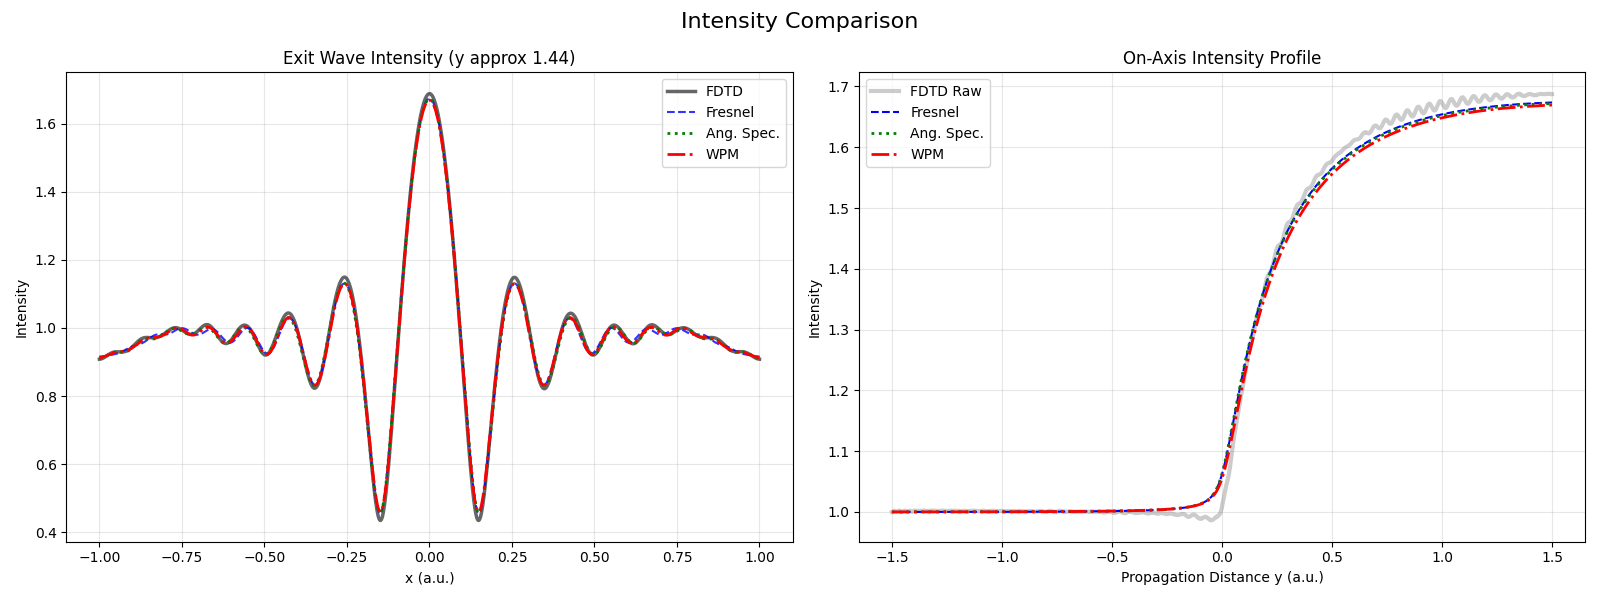

In [8]:
# --- Quantitative Analysis ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Exit Wave Profile (Transverse)
idx_exit = NY - 20 
x_axis = np.linspace(XMIN, XMAX, NX)

plt.suptitle("Intensity Comparison", fontsize=16)
ax1.plot(x_axis, np.abs(psi_fdtd[idx_exit, :]), 'k-', lw=2.5,  alpha=0.6, label='FDTD')
ax1.plot(x_axis, np.abs(psi_fresnel[idx_exit, :]), 'b--', alpha=0.8, label='Fresnel')
ax1.plot(x_axis, np.abs(psi_as[idx_exit, :]), 'g:', lw=2, label='Ang. Spec.')
ax1.plot(x_axis, np.abs(psi_wpm[idx_exit, :]), 'r-.', lw=2, label='WPM')

ax1.set_title(f"Exit Wave Intensity (y approx {y[idx_exit]:.2f})")
ax1.set_xlabel("x (a.u.)")
ax1.set_ylabel("Intensity")
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Longitudinal Profile (On-Axis)
ix_center = NX // 2
I_fdtd_raw = np.abs(psi_fdtd[:, ix_center])
I_fresnel = np.abs(psi_fresnel[:, ix_center])
I_as = np.abs(psi_as[:, ix_center])
I_wpm = np.abs(psi_wpm[:, ix_center])


ax2.plot(y, I_fdtd_raw, color='gray', alpha=0.4, lw=3, label='FDTD Raw')
ax2.plot(y, I_fresnel, 'b--', label='Fresnel')
ax2.plot(y, I_as, 'g:', lw=2, label='Ang. Spec.')
ax2.plot(y, I_wpm, 'r-.', lw=2, label='WPM')

ax2.set_title("On-Axis Intensity Profile")
ax2.set_xlabel("Propagation Distance y (a.u.)")
ax2.set_ylabel("Intensity")
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# --- Video Visualization ---
def create_energy_video(snapshots, extent, filename="fdtd_energy_flow.mp4", skip=10):
    fig, ax = plt.subplots(figsize=(6, 8))
    
    # helper
    def get_intensity(phi, psi):
        return phi**2 + psi**2

    # Initial frame
    t0, phi0, psi0 = snapshots[0]
    I_0 = get_intensity(phi0, psi0)
    
    im = ax.imshow(I_0, extent=extent, cmap='inferno', origin='upper', animated=True, vmin=0, vmax=2.5)
    ax.set_title(f"Intensity (t={t0:.2f})")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    pbar = tqdm(total=len(snapshots)//skip, desc="Rendering Video")

    def update(frame_idx):
        t, phi, psi = snapshots[frame_idx]
        I_t = get_intensity(phi, psi)
        im.set_array(I_t)
        ax.set_title(f"Intensity (t={t:.1f} a.u.)")
        pbar.update(1)
        return im,

    ani = animation.FuncAnimation(
        fig, update, 
        frames=range(0, len(snapshots), skip), 
        interval=30, blit=True
    )
    
    ani.save(filename, writer='ffmpeg', fps=30, dpi=100)
    plt.close(fig)
    pbar.close()
    return filename

# Run
video_file = create_energy_video(snapshots, extent_ext, skip=1)
print(f"Video saved to {video_file}")
Video(video_file)

Rendering Video: 2it [00:00,  4.89it/s]               

Video saved to fdtd_energy_flow.mp4
